<a href="https://colab.research.google.com/github/sepehr21ar/Deep_Learning_Project/blob/main/Human_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('float32')
#'mixed_float16'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow_probability as tfp

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown


In [ ]:
!unzip /content/human-emotions-datasethes.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
train_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
class_names = ["angry", "happy", "sad"]

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE" :8,
    "IM_SIZE" : 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.15,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 8,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 256,
    "N_DENSE_2": 64,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    batch_size=None,
    color_mode="rgb",
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=42,
).batch(CONFIGURATION["BATCH_SIZE"], drop_remainder=True)

Found 6799 files belonging to 3 classes.


In [ ]:
for image_batch, label_batch in train_dataset.take(1):
    print("شکل تصاویر:", image_batch.shape)
    print("شکل برچسب‌ها:", label_batch.shape)

شکل تصاویر: (8, 256, 256, 3)
شکل برچسب‌ها: (8, 3)


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    batch_size=None,
    color_mode="rgb",
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=42,
).batch(CONFIGURATION["BATCH_SIZE"], drop_remainder=True)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(8, 256, 256, 3), dtype=float32, numpy=
array([[[[168.      , 168.      , 168.      ],
         [168.      , 168.      , 168.      ],
         [176.9375  , 176.9375  , 176.9375  ],
         ...,
         [245.      , 245.      , 245.      ],
         [245.      , 245.      , 245.      ],
         [245.      , 245.      , 245.      ]],

        [[168.      , 168.      , 168.      ],
         [168.      , 168.      , 168.      ],
         [176.9375  , 176.9375  , 176.9375  ],
         ...,
         [246.0664  , 246.0664  , 246.0664  ],
         [246.625   , 246.625   , 246.625   ],
         [246.625   , 246.625   , 246.625   ]],

        [[168.      , 168.      , 168.      ],
         [168.      , 168.      , 168.      ],
         [176.46484 , 176.46484 , 176.46484 ],
         ...,
         [245.41016 , 245.41016 , 245.41016 ],
         [245.625   , 245.625   , 245.625   ],
         [245.625   , 245.625   , 245.625   ]],

        ...,

        [[104.375   , 104.375   ,

In [ ]:
augmentation_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.03, 0.03)),
    RandomFlip("horizontal"),
    RandomContrast(0.06)
])

In [ ]:
0.03*360

10.799999999999999

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
   Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
   Rescaling(1./255)
])

In [ ]:
def augment_layer(image, label):
    return augmentation_layers(image, training=True), label

In [ ]:
for image_batch, label_batch in train_dataset.take(1):
    print("شکل تصاویر:", image_batch.shape)
    print("شکل برچسب‌ها:", label_batch.shape)

شکل تصاویر: (8, 256, 256, 3)
شکل برچسب‌ها: (8, 3)


In [ ]:

training_dataset = (
    train_dataset.map(augment_layer, tf.data.AUTOTUNE ).prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    val_dataset.map(augment_layer, tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
)

In [ ]:
dataset_size = tf.data.experimental.cardinality(training_dataset).numpy()
print(f"تعداد بچ‌ها در دیتاست: {dataset_size}")


تعداد بچ‌ها در دیتاست: 849


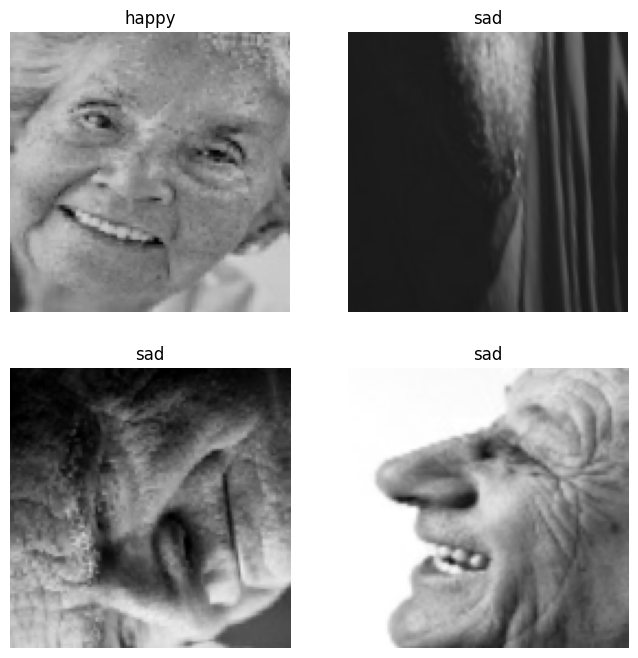

In [ ]:

plt.figure(figsize=(8, 8))
for images, labels in training_dataset.shuffle(buffer_size=25).take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)

        img = tf.image.resize(images[i], [128, 128])

        plt.imshow(img.numpy().astype("float32") / 255)
        plt.title(class_names[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

plt.show()

In [ ]:
plt.close()

In [ ]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 3), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 3), dtype=tf.float32, name=None))>

# Lenet

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3) ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_328 (Conv2D)                  │ (None, 254, 254, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_332              │ (None, 254, 254, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 127, 127, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 127, 127, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_329 (Conv2D)                  │ (None, 125, 125, 20)        │           1,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_333              │ (None, 125, 125, 20)        │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 62, 62, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 76880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │      19,681,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_334              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_335              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,701,255 (75.15 MB)

 Trainable params: 19,700,559 (75.15 MB)

 Non-trainable params: 696 (2.72 KB)

# ResNet


In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training=training)

    return x

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training=training)
    x = self.custom_conv_2(x, training=training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training=training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training=training)
    x = self.conv_2_2(x, training=training)
    x = self.conv_2_3(x, training=training)

    x = self.conv_3_1(x, training=training)
    x = self.conv_3_2(x, training=training)
    x = self.conv_3_3(x, training=training)
    x = self.conv_3_4(x, training=training)

    x = self.conv_4_1(x, training=training)
    x = self.conv_4_2(x, training=training)
    x = self.conv_4_3(x, training=training)
    x = self.conv_4_4(x, training=training)
    x = self.conv_4_5(x, training=training)
    x = self.conv_4_6(x, training=training)

    x = self.conv_5_1(x, training=training)
    x = self.conv_5_2(x, training=training)
    x = self.conv_5_3(x, training=training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = True)
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)         │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

# New Section

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights.keras',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


NameError: name 'ModelCheckpoint' is not defined

In [ ]:
loss_function = CategoricalCrossentropy(from_logits=False)
# loss_function = SparseCategoricalCrossentropy(from_logits=False)


In [ ]:
# top_k_accuracy = TopKCategoricalAccuracy(k=2, name="top_2_accuracy")

# metrics = [
#     CategoricalAccuracy(name="accuracy"),
#     lambda y_true, y_pred: top_k_accuracy(y_true, tf.cast(y_pred, tf.float32))
# ]
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_3_accuracy")]

In [ ]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = resnet_34.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks = [checkpoint_callback, early_stopping]
    )

Epoch 1/20


KeyboardInterrupt: 

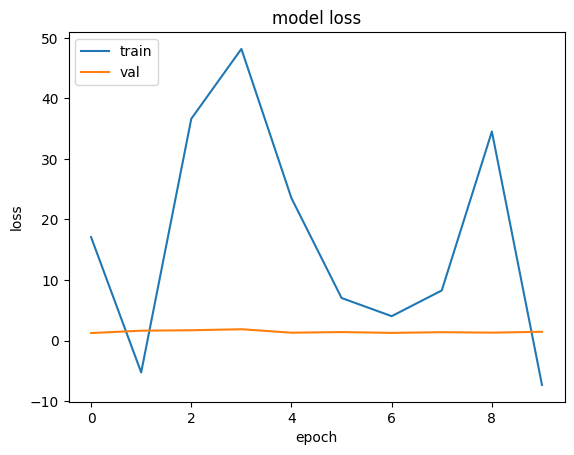

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
lenet_model.evaluate(validation_dataset)

In [ ]:
test_image = cv.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/150736.jpg_rotation_1.jpg")
im = tf.constant(test_image  , dtype = tf.float32)
print(im.shape)
im = tf.expand_dims(im, axis = 0)
print(im.shape)
# print(tf.argmax(lenet_model.predict(im),axis = -1))
print(class_names[tf.argmax(lenet_model.predict(im),axis = -1).numpy()[0]])

In [ ]:
plt.figure(figsize=(12,12))
for images,labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(((images[i].numpy())/255).astype("float32"))
    plt.title("True label : "+class_names[tf.argmax(labels[i], axis = 0).numpy()]+"\n" + "Predict label : " + class_names[tf.argmax(lenet_model.predict(tf.expand_dims(images[i], axis = 0)),axis = -1).numpy()[0]])
    plt.axis("off")

In [ ]:
predicted = []
labels = []

for im , label in  val_dataset:
  predicted.append(lenet_model.predict(im))
  labels.append(label.numpy())

In [ ]:
print(np.argmax(labels[:-1 ], axis = -1))

TFRECORD

In [ ]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
train_dataset

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )


In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# val_parsed_dataset = (
#     val_recons_dataset
#     .map(parse_tfrecords)
#     .batch(CONFIGURATION["BATCH_SIZE"])
#     .prefetch(tf.data.AUTOTUNE)
# )


In [ ]:
parsed_dataset

In [ ]:
for i in parsed_dataset.take(1):
  print(i)